## STAR-RIS Aided Multi-Cell NOMA

### Necessary Imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
import simcomm.metrics as metrics
import simcomm.utils as utils
from simcomm.fading import get_channel, get_fading, rician_fading
from simcomm.visualize import plot_network

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

os.makedirs("./data/star_ris_mc_noma/", exist_ok=True)
save_dir = os.path.abspath("./data/star_ris_mc_noma/")

### System Model

Parameters

In [2]:
# Multi-cell NOMA
N = 3  # Number of users
N_index = np.arange(N)  # Index of users
M = 2  # Number of BSs
M_index = np.arange(M)  # Index of BSs
T = 290  # Temperature in Kelvin
BANDWIDTH = 10e6  # bandwidth in Hz
NOISE = utils.get_noise(BANDWIDTH, T, 43)  # noise power in dBm
NOISE_LIN = utils.dbm2pow(NOISE)  # noise power in linear scale
S = 8000  # Number of monte carlo simulations
K_rice = 5  # Rician factor
L = 6  # Number of RIS elements

# Power parameters
Pt = np.linspace(-40, 20, 120)  # transmit power in dBm
Pt_lin = utils.dbm2pow(Pt)  # transmit power in linear scale
P_circuit = 10e-5  # circuit power in Watts

Creating Layout

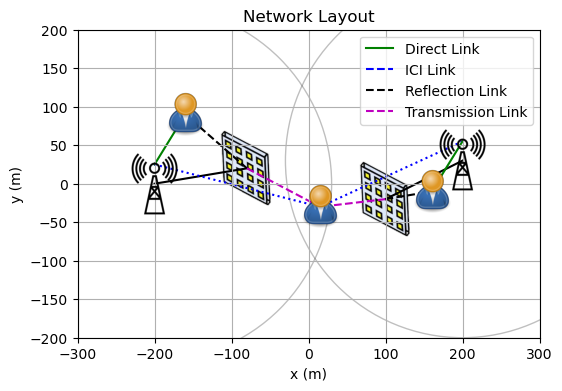

In [3]:
bs_pos = np.array([[-200, 0, 10], [200, 30, 10]])
user_pos = np.array([[-160, 90, 0], [15, -30, 0], [160, -10, 0]])
ris_pos = np.array([[-80, 20], [100, -20]])

plot_network(300, 230, bs_pos, user_pos, ris_pos,
             save=True, save_path=save_dir)

### Monte Carlo Simulations

In [4]:
def compute_distances(bs_pos, ris_pos, user_pos):
    """
    Compute the distances between BSs, RIS, and users.
    """
    M, N = len(bs_pos), len(user_pos)
    distance_mn_mat = np.zeros((M, N), dtype=np.float64)
    distance_mr_mat = np.zeros((M), dtype=np.float64)
    distance_rn_mat = np.zeros((M, N), dtype=np.float64)

    for m in range(M):
        distance_mr_mat[m] = utils.distance(bs_pos[m], ris_pos[m])
        for n in range(N):
            distance_mn_mat[m, n] = utils.distance(bs_pos[m], user_pos[n])
            distance_rn_mat[m, n] = utils.distance(ris_pos[m], user_pos[n])

    return distance_mn_mat, distance_mr_mat, distance_rn_mat

In [5]:
def compute_coefficients(L):
    """
    Compute the reflection and transmission coefficients of the RIS elements.
    """
    beta_r = np.zeros((L), dtype=np.float64)
    beta_t = np.zeros((L), dtype=np.float64)
    theta_r = np.zeros((L), dtype=np.float64)
    theta_t = np.zeros((L), dtype=np.float64)
    reflection_mat = np.zeros((L, L), dtype=np.complex128)
    transmission_mat = np.zeros((L, L), dtype=np.complex128)

    for l in range(L):
        beta_r[l] = np.random.uniform(0, 1)
        beta_t[l] = 1 - beta_r[l]
        theta_r[l] = np.random.uniform(np.pi, 2 * np.pi)
        theta_t[l] = np.random.uniform(np.pi, 2 * np.pi)
        reflection_mat[l, l] = np.sqrt(beta_r[l]) * np.exp(1j * theta_r[l])
        transmission_mat[l, l] = np.sqrt(beta_t[l]) * np.exp(1j * theta_t[l])

    return beta_r, beta_t, theta_r, theta_t, reflection_mat, transmission_mat

In [6]:
def compute_channel_gains(
    M, N, L, distance_mn_mat, distance_mr_mat, distance_rn_mat, K_rice
):
    """
    Compute the combined channel gains between BSs and users.
    """
    h_mn = np.zeros((M, N), dtype=np.complex128)

    for m in range(M):
        for n in range(N):
            ETA = 3.5 if (n == 0 or n == 2) else 4
            h_mn[m, n] = get_channel(get_fading("rayleigh"), distance_mn_mat[m, n], ETA)

    h_mr = np.zeros((M, L), dtype=np.complex128)
    h_rn = np.zeros((M, L, N), dtype=np.complex128)
    H_mn = np.zeros((M, N), dtype=np.complex128)

    ETA = 2.2
    (
        beta_r,
        beta_t,
        theta_r,
        theta_t,
        reflection_mat,
        transmission_mat,
    ) = compute_coefficients(L)

    for m in range(M):
        for l in range(L):
            h_mr[m, l] = get_channel(get_fading("rayleigh"), distance_mr_mat[m], ETA)
            for n in range(N):
                h_rn[m, l, n] = get_channel(
                    get_fading("rician", K=K_rice, P_los=2, link=False),
                    distance_rn_mat[m, n],
                    ETA,
                )

                if n == 0 or n == 2:
                    ris_component = np.sum(
                        np.conj(h_rn[m, :, n])
                        * beta_r[:]
                        * h_mr[m, :]
                        * np.exp(1j * theta_r[:])
                    )
                else:
                    ris_component = np.sum(
                        np.conj(h_rn[m, :, n])
                        * beta_t[:]
                        * h_mr[m, :]
                        * np.exp(1j * theta_t[:])
                    )
                H_mn[m, n] = h_mn[m, n] + ris_component

    G_mn = np.abs(H_mn) ** 2

    return G_mn

In [7]:
rate = np.zeros((S, N))
sum_rate = np.zeros((S, len(Pt_lin)))
outage = np.zeros((S, N, len(Pt_lin)))
energy_eff = np.zeros((S, len(Pt_lin)))
spectral_eff = np.zeros((S, len(Pt_lin)))
r_min = 1

for mc in range(S):
    # Compute distances between BSs, RISs and users
    distance_mn_mat, distance_mr_mat, distance_rn_mat = compute_distances(
        bs_pos, ris_pos, user_pos
    )

    # Compute the channel gains
    G_mn = compute_channel_gains(
        M, N, L, distance_mn_mat, distance_mr_mat, distance_rn_mat, K_rice
    )

    # Assigning alpha factors for fixed allocation
    alpha_1f = 0.75
    alpha_2f = 0.83

    for i in range(len(Pt_lin)):
        # Rate for user 1
        # 1c: center user of cell 1 (BS 1)
        gamma_1c = Pt_lin[i] * G_mn[0, 0] / (NOISE_LIN)
        rate[mc, 0] = np.log2(1 + ((1 - alpha_1f) * gamma_1c))

        # Rate for user 3
        # 2c: center user of cell 2 (BS 2)
        gamma_2c = Pt_lin[i] * G_mn[1, 2] / (NOISE_LIN)
        rate[mc, 2] = np.log2(1 + ((1 - alpha_2f) * gamma_2c))

        # Rate for user 2
        gamma_1f = (
            Pt_lin[i] * G_mn[0, 1] / (Pt_lin[i] * G_mn[1, 1] + NOISE_LIN)
        )  # 1f: edge user of cell 1 (BS 1)
        gamma_2f = (
            Pt_lin[i] * G_mn[1, 1] / (Pt_lin[i] * G_mn[0, 1] + NOISE_LIN)
        )  # 2f: edge user of cell 2 (BS 2)
        rate[mc, 1] = np.log2(
            1
            + ((alpha_1f * gamma_1f) + (alpha_2f * gamma_2f))
            / (((1 - alpha_1f) * gamma_1f) + ((1 - alpha_2f) * gamma_2f) + 1)
        )

        # Sum rate
        sum_rate[mc, i] = np.sum(rate[mc, :])

        # Outage
        outage[mc, 0, i] = metrics.outage_probability(rate[mc, 0], r_min)
        outage[mc, 1, i] = metrics.outage_probability(rate[mc, 1], r_min)
        outage[mc, 2, i] = metrics.outage_probability(rate[mc, 2], r_min)

        # Energy efficiency
        energy_eff[mc, i] = sum_rate[mc, i] / (Pt_lin[i] + P_circuit)

        # Spectral efficiency
        # already normalized by bandwidth
        spectral_eff[mc, i] = sum_rate[mc, i]

# Averaging over all monte carlo simulations
avg_sum_rate = np.mean(sum_rate, axis=0)
avg_outage = np.mean(outage, axis=0)
avg_energy_eff = np.mean(energy_eff, axis=0)
avg_spectral_eff = np.mean(spectral_eff, axis=0)

### Plots

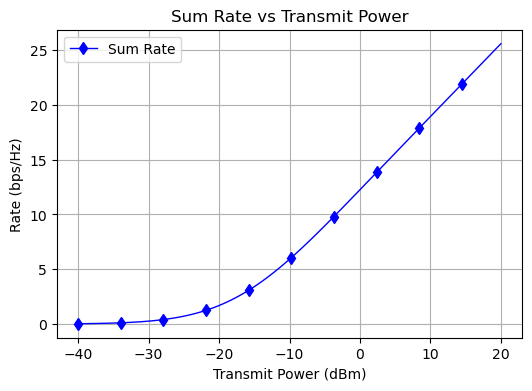

In [8]:
# Sum rate vs transmit power
np.save(os.path.join(save_dir, "sum_rate.npy"), avg_sum_rate)

fig = plt.figure(figsize=(6, 4))
plt.plot(
    Pt, avg_sum_rate, "b-", label="Sum Rate", linewidth=1, marker="d", markevery=12
)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("Sum Rate vs Transmit Power")
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_dir, "sum_rate.pdf"), bbox_inches="tight")
plt.show()

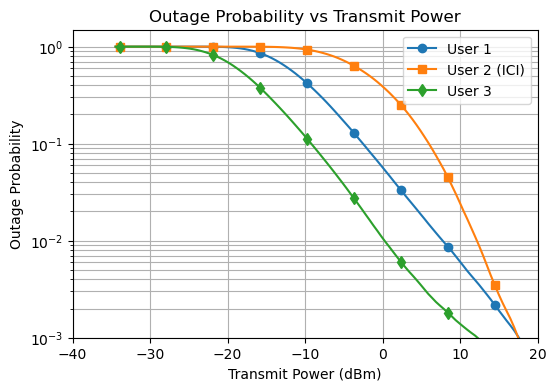

In [9]:
# Outage probability vs transmit power
window_size = 12
rolling_outage = np.zeros((N, len(Pt)))
for i in range(N):
    rolling_outage[i] = utils.rolling_mean(avg_outage[i], window_size)

np.save(os.path.join(save_dir, "outage.npy"), rolling_outage)

fig, ax = plt.subplots(figsize=(6, 4))
plt.semilogy(Pt, rolling_outage[0], label="User 1", marker="o", markevery=12)
plt.semilogy(Pt, rolling_outage[1],
             label="User 2 (ICI)", marker="s", markevery=12)
plt.semilogy(Pt, rolling_outage[2], label="User 3", marker="d", markevery=12)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability vs Transmit Power")
plt.xlim(-40, 20)
plt.ylim(1e-3, None)
plt.legend()
plt.grid(which="both")
plt.savefig(os.path.join(save_dir, "outage.pdf"), bbox_inches="tight")
plt.show()

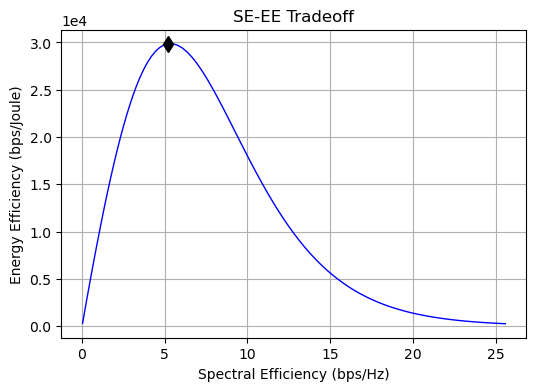

In [10]:
# SE-EE tradeoff
np.save(os.path.join(save_dir, "avg_spectral_eff.npy"), avg_spectral_eff)
np.save(os.path.join(save_dir, "avg_energy_eff.npy"), avg_energy_eff)

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(avg_spectral_eff, avg_energy_eff, "b-", linewidth=1)
plt.xlabel("Spectral Efficiency (bps/Hz)")
plt.ylabel("Energy Efficiency (bps/Joule)")
plt.title("SE-EE Tradeoff")
plt.grid()

# Find the peak point
peak_idx = np.argmax(avg_energy_eff)
peak_x = avg_spectral_eff[peak_idx]
peak_y = avg_energy_eff[peak_idx]

# Add a marker at the peak point
plt.plot(peak_x, peak_y, marker="d", markersize=8, color="black")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.savefig(os.path.join(save_dir, "se_ee_tradeoff.pdf"), bbox_inches="tight")
plt.show()